In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import pandas as pd 
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import matplotlib.image as mpimg

print("Impporting library is successful")

Impporting library is successful


In [2]:
from google.colab import drive

drive.mount('/content/GDrive/')

print("Drive mounted  successfully")

Mounted at /content/GDrive/
Drive mounted  successfully


In [3]:
PATH = 'GDrive/My\ Drive/Dataset/cell_images/'

parasitized = os.listdir ("GDrive/My Drive/Dataset/cell_images/Parasitized/")
num_of_parasitized= len(parasitized)


uninfected = os.listdir ("GDrive/My Drive/Dataset/cell_images/Uninfected/")
num_of_uninfected = len(uninfected)

print ("Total images for infected cells ", num_of_parasitized)
print ("Total images for uninfected cells ", num_of_uninfected)


Total images for infected cells  13779
Total images for uninfected cells  13779


In [4]:
images = []
image_labels = []

for p in parasitized:
    print(p)
    try:
    
        reading_image = cv2.imread('GDrive/My Drive/Dataset/cell_images/Parasitized/'+p)
        image_array = Image.fromarray(reading_image , 'RGB')

        image_resize = image_array.resize((64 , 64))
        #rotate_image_60_degree = image_resize.rotate(60)
        #blur = cv2.blur(np.array(image_resize) ,(10,10))

        images.append(np.array(image_resize))
        #images.append(np.array(rotate_image_60_degree))
        #images.append(np.array(blur))
        
        #image_labels.append(0)
        #image_labels.append(0)
        image_labels.append(0)

    except AttributeError:
        print('')

for u in uninfected:
    print(u)

    try:
        
        reading_image = cv2.imread('GDrive/My Drive/Dataset/cell_images/Uninfected/'+u)
        image_array = Image.fromarray(reading_image , 'RGB')

        image_resize = image_array.resize((64 , 64))
        #rotate_image_60_degree = image_resize.rotate(60)

        images.append(np.array(image_resize))
        #images.append(np.array(rotate_image_60_degree))

        image_labels.append(1)
        image_labels.append(1)

        
    except AttributeError:
        print('')

Streaming output truncated to the last 5000 lines.
C201ThinF_IMG_20150930_142848_cell_48.png
C202ThinF_IMG_20151015_151254_cell_255.png
C189P150ThinF_IMG_20151203_140902_cell_27.png
C179P140ThinF_IMG_20151127_153521_cell_105.png
C201ThinF_IMG_20150930_143129_cell_48.png
C188P149ThinF_IMG_20151203_134449_cell_76.png
C202ThinF_IMG_20151015_152200_cell_4.png
C178P139NThinF_IMG_20151201_154524_cell_48.png
C203ThinF_IMG_20151029_104112_cell_28.png
C180P141NThinF_IMG_20151201_163848_cell_1.png
C175P136NThinF_IMG_20151127_141325_cell_32.png
C185P146ThinF_IMG_20151203_110448_cell_96.png
C183P144NThinF_IMG_20151201_224107_cell_69.png
C189P150ThinF_IMG_20151203_140902_cell_23.png
C173P134NThinF_IMG_20151130_115339_cell_19.png
C205ThinF_IMG_20151106_151514_cell_117.png
C189P150ThinF_IMG_20151203_141406_cell_83.png
C179P140ThinF_IMG_20151127_153420_cell_158.png
C189P150ThinF_IMG_20151203_141615_cell_18.png
C206ThinF_IMG_20151029_140511_cell_203.png
C169P130ThinF_IMG_20151118_172913_cell_18.png
C18

In [5]:
image_cells = np.array(images)
image_labels = np.array(image_labels)

np.save('Image cells' , image_cells)

np.save('Image labels' , image_labels)

In [6]:
print('Image cells : {} | Image labels: {}'.format(image_cells.shape , image_labels.shape))

Image cells : (27558, 64, 64, 3) | Image labels: (41337,)


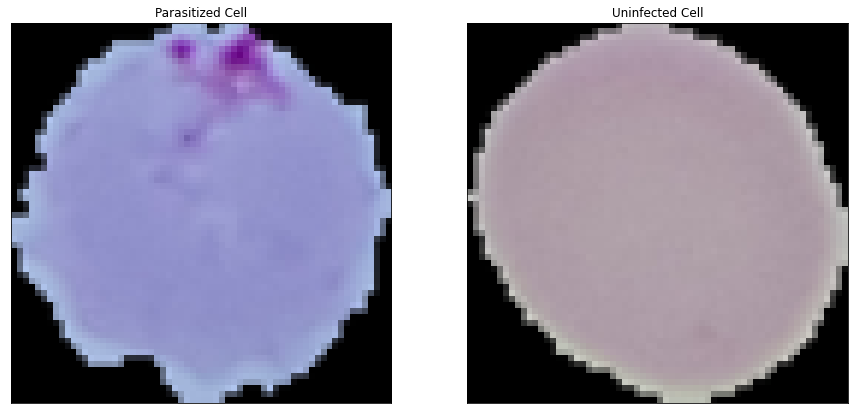

In [8]:
plt.figure(1, figsize = (15 , 7))
plt.subplot(1 , 2 , 1)
plt.imshow(image_cells[0])
plt.title('Parasitized Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(image_cells[20000])
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

In [9]:
n = np.arange(image_cells.shape[0])
np.random.shuffle(n)
image_cells = image_cells[n]
image_labels = image_labels[n]

Normalization

In [10]:
image_cells = image_cells.astype(np.float32)
image_labels = image_labels.astype(np.int32)
image_cells = image_cells/255

Data spliting into Train-Valid-Test

In [11]:
from sklearn.model_selection import train_test_split

train_x , x , train_y , y = train_test_split(image_cells , image_labels , 
                                            test_size = 0.3 ,
                                            random_state = 111)

eval_x , test_x , eval_y , test_y = train_test_split(x , y , 
                                                    test_size = 0.5 , 
                                                    random_state = 111)

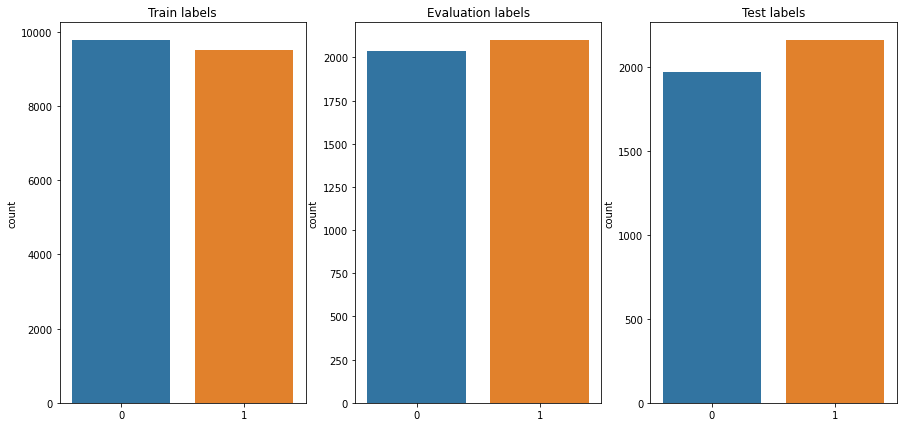

In [12]:
plt.figure(1 , figsize = (15 ,7))
n = 0 
for z , j in zip([train_y , eval_y , test_y] , ['Train labels','Evaluation labels','Test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [13]:
print('Train data shape {} ,Evaluation data shape {} , Test data shape {}'.format(train_x.shape,
                                                                           eval_x.shape ,
                                                                           test_x.shape))

Train data shape (19290, 64, 64, 3) ,Evaluation data shape (4134, 64, 64, 3) , Test data shape (4134, 64, 64, 3)


In [14]:
from tensorflow.python.framework import ops

In [15]:
ops.reset_default_graph()

def cnn_model_function(features , labels , mode):

    input_layers = tf.reshape(features['x'] , [-1 , 64 , 64 ,3])    

    convolution_1 = tf.layers.conv2d(
        inputs = input_layers , 
        filters = 64 , 
        kernel_size = [5 , 5],
        padding = 'same',
        activation = tf.nn.relu
        ) 
    
    convolution_2 = tf.layers.conv2d(
        inputs = convolution_1, 
        filters = 100,
        kernel_size = [3 , 3],
        padding = 'valid',
        activation = tf.nn.relu
        )
    

    convolution_3 = tf.layers.conv2d(
        inputs = convolution_2, 
        filters = 15,
        kernel_size = [3 , 3],
        padding = 'same',
        activation = tf.nn.relu
        )
    
    max_pool_2 = tf.layers.max_pooling2d(inputs = convolution_3 , pool_size = [2 , 2] , strides = 2 )
    
    pool_2_flatten = tf.layers.flatten(max_pool_2)

    density_1 = tf.layers.dense(
        inputs = pool_2_flatten,
        units = 2048,
        activation = tf.nn.relu
        )
    density_2 = tf.layers.dense(
        inputs = density_1,
        units = 1024,
        activation = tf.nn.relu
        )
    
    dropout = tf.layers.dropout(
        inputs = density_2, 
        rate = 0.3, 
        training = (mode == "train"))

    
    logits = tf.layers.dense(
        inputs = dropout ,
        units = 10
        )
    
    predictions = {
        'predict_classes': tf.argmax(input = logits , axis = 1),
        'probabilities': tf.nn.softmax(logits , name = 'softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode , 
                                          predictions = predictions)
    
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels = labels , logits = logits)
  
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.0001)
        train_optimizer = optimizer.minimize(loss = loss , 
                                      global_step = tf.train.get_global_step())
        
        return tf.estimator.EstimatorSpec(mode = mode , 
                                            loss = loss , 
                                            train_op = train_optimizer 
                                           )
    evaluation_metric_optimizer = {'accuracy' : tf.metrics.accuracy(labels = labels ,
                                         predictions =  predictions['predict_classes'])}
    
    return tf.estimator.EstimatorSpec(mode = mode , 
                                      loss = loss , 
                                      eval_metric_ops = evaluation_metric_optimizer)    

In [16]:
malaria_cell_detector = tf.estimator.Estimator(model_fn = cnn_model_function , model_dir = '/tmp/modelchkpt')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/modelchkpt', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [18]:
tensors_to_log = {'probabilities':'softmax_tensor'}
logging_hook = tf.train.LoggingTensorHook(
    tensors = tensors_to_log , every_n_iter = 10 
                 )

In [19]:
train_input_function = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_x},
    y = train_y,
    batch_size = 100 , 
    num_epochs = None , 
    shuffle = True
    )

In [20]:
malaria_cell_detector.train(input_fn = train_input_function ,
                            steps = 100,
                            hooks = [logging_hook])

#malaria_cell_detector.train(input_fn = train_input_function , steps = 10000) 

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a fut

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/modelchkpt/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:probabilities = [[0.09836549 0.0961592  0.09389104 0.09902742 0.10685132 0.09793717
  0.09271611 0.10806667 0.1137275  0.093258  ]
 [0.1099124  0.11303003 0.0945323  0.08458019 0.10585485 0.09666051
  0.08976004 0.10780771 0.10371257 0.09414943]
 [0.10262389 0.10627278 0.08671817 0.09733171 0.09904233 0.09850444
  0.09655696 0.10293483 0.1144953  0.09551964]
 [0.10005751 0.1086522  0.08937036 0.098494   0.10339271 0.09895177
  0.09000544 0.11061512 0.11134844 0.08911248]

In [21]:
evaluation_input_function = tf.estimator.inputs.numpy_input_fn(
    x = {'x': eval_x},
    y = eval_y , 
    num_epochs = 10 , 
    shuffle = False
    )
evaluation_results = malaria_cell_detector.evaluate(input_fn = evaluation_input_function)
print(evaluation_results)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a fut

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-11T17:16:27
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/modelchkpt/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 569.04534s
INFO:tensorflow:Finished evaluation at 2021-12-11-17:25:57
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.63473636, global_step = 100, loss = 0.6326056
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/modelchkpt/model.ckpt-100
{'accuracy': 0.63473636, 'loss': 0.6326056, 'global_step': 100}


In [23]:
test_input_function = tf.estimator.inputs.numpy_input_fn(
    x = {'x': test_x},
    y = test_y , 
    num_epochs = 10 , 
    shuffle = False
    )
test_results = malaria_cell_detector.evaluate(input_fn = test_input_function)
print(test_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-11T17:35:02


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a fut

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/modelchkpt/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


KeyboardInterrupt: ignored

In [ ]:
train_input_function = tf.estimator.inputs.numpy_input_fn(
    x = {'x': train_x},
    y = train_y , 
    num_epochs = 10 , 
    shuffle = False
    )
train_results = malaria_cell_detector.evaluate(input_fn = train_input_function)
print(test_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-12-09T10:10:37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a fut

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/modelchkpt/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 6843.22275s
INFO:tensorflow:Finished evaluation at 2021-12-09-12:04:41
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.9653506, global_step = 2000, loss = 0.10730468
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/modelchkpt/model.ckpt-2000
{'accuracy': 0.9560716, 'loss': 0.13182649, 'global_step': 2000}


In [24]:
prediction_input_function = tf.estimator.inputs.numpy_input_fn(
    x = {'x' : test_x},
    y = test_y,
    num_epochs = 1,
    shuffle = False
    )

y_pred = malaria_cell_detector.predict(input_fn = prediction_input_function)
predict_classes = [p['predict_classes'] for p in y_pred]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:563: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a fut

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/modelchkpt/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [25]:
from sklearn.metrics import confusion_matrix, precision_score , recall_score, f1_score , accuracy_score
print('{} \n{} \n{} \n{}'.format(precision_score(test_y , predict_classes) , 
                           recall_score(test_y , predict_classes) ,
                           f1_score(test_y , predict_classes) , 
                           accuracy_score(test_y , predict_classes)))

0.745398773006135 
0.45 
0.5612009237875288 
0.6323173681664248


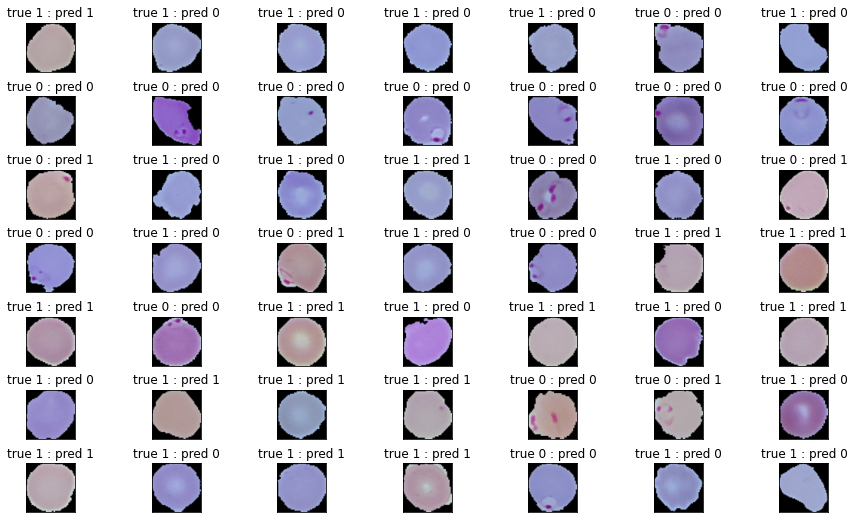

In [26]:
plt.figure(1 , figsize = (15 , 9))
n = 0 
for i in range(49):
    n += 1 
    r = np.random.randint( 0  , test_x.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(test_x[r[0]])
    plt.title('true {} : pred {}'.format(test_y[r[0]] , predict_classes[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

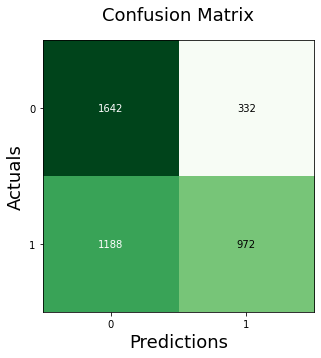

In [27]:
from mlxtend.plotting import plot_confusion_matrix
conf_matrix = confusion_matrix(test_y, predict_classes)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix, figsize=(5,5), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()